In [4]:
import numpy as np

%config Completer.use_jedi = False

# Simulation Object

## Integrators

In [5]:
from abc import abstractmethod

class Integrator:
    def __init__(self, dt):
        self.dt = dt
        
    def connect(self, positions, velocities, masses):
        # connects integrator with engine
        self.positions = positions
        self.velocities = velocities
        self.masses = masses
    
    @abstractmethod
    def setup(self):
        # setup variables
        self.force = np.empty(self.velocities.shape, dtype=np.float32)
        pass
    
    @abstractmethod
    def initial_integrate(self):
        self.velocities += self.dtfm * self.forces
        self.positions += self.dtv * self.velocities
    
    @abstractmethod
    def final_integrate(self):
        self.velocities += self.dtfm * self.forces

class VelocityVerletIntegrator(Integrator):
    constants = {
        'LJ' : {'ftm2v' : 1.0},
        'real' : {'ftm2v' : 0.00041839999997254776},
        'metal' : {'ftm2v' : 9648.533823273016},
    }
    
    def __init__(self, dt, units='LJ'):
        self.dt = dt
        try:
            self.ftm2v = self.constants[units]['ftm2v']
        except KeyError as e:
            raise KeyError('"ftm2v" for Unit("") not found'.format(unit))
        
    def setup(self):
        # setup variables
        self.forces = np.zeros(self.velocities.shape, dtype=np.float64)
        self.dtv = self.dt
        self.dtf = 0.5*self.dt * self.ftm2v
        self.dtfm =  np.atleast_2d(self.dtf / self.masses).T
        
    def initial_integrate(self):
        self.velocities += self.dtfm * self.forces
        self.positions += self.dtv * self.velocities
        
    def final_integrate(self):
        self.velocities += self.dtfm * self.forces

## Pair Interactions

In [46]:
class Force:
    def __init__(self, cutoff):
        self.cutoff = cutoff
        self.cutoff = cutoff
        self.cutsq = cutoff**2
        
    def connect(self, engine):
        # connects integrator with engine
        self.positions = engine.positions
        self.box = engine.box
        self.pe = 0.0
        
        self.neigh = engine.neigh
        self.neighborlist = engine.neigh.neighborlist
        self.ghost_images = engine.neigh.ghost_images       
        self.n_locals = engine.neigh.n_locals
        
    def fix_pbc(self, delx, ghost_images):
        img = self.neigh.convert_ghostimage_to_3d(ghost_images)
        delx -= img[:,0]*self.box[0]
        delx -= img[:,1]*self.box[1]
        delx -= img[:,2]*self.box[2]
        
        
    def setup(self):
        # setup variables, reimplement if needed
        pass
        
    @abstractmethod
    def compute(self, forces):
        # computes forces, needs to be reimplemented
        pass
    
    def get_current_state(self, return_forces=True):
        "gets the potential energy and forces of the current snapshot"
        forces = np.zeros(self.positions.shape, dtype=np.float64)
        old_pe = self.pe
        self.compute(forces)
        new_pe, self.pe = self.pe, old_pe
        if return_forces:
            return forces, new_pe
        else:
            return new_pe

class LennardJones(Force):
    def __init__(self, epsilon, sigma, cutoff, shift=True):
        super().__init__(cutoff)
        
        self.epsilon = epsilon
        self.sigma = sigma
        
        self.c12 = 4*epsilon*sigma**12
        self.c6 = 4*epsilon*sigma**6
        
        self.f_c12 = 12 * self.c12 
        self.f_c6 = 6 * self.c6
        
        if shift:
            r6inv = 1.0 / cutoff**6
            self.offset = r6inv * (self.c12*r6inv - self.c6)
        else:
            self.offset = 0.0
            
    def compute(self, forces):        
        for i, xtmp in enumerate(self.positions):
            n_local = self.n_locals[i]
            if n_local > 0:
                neighbors = self.neighborlist[i, :n_local]
                
                delx = xtmp - self.positions[neighbors]
                #self.fix_pbc(delx, self.ghost_images[i, :n_local])

                rsq = np.sum(np.power(delx, 2))
                if rsq < self.cutsq:
                    r2inv = 1.0 / rsq
                    r6inv = r2inv * r2inv * r2inv

                    forcelj = r6inv * (self.f_c12*r6inv - self.f_c6 )
                    forcelj *= r2inv

                    forces[i] += (delx * forcelj)[0]

                    forces[neighbors] -= delx * forcelj

                    self.pe += np.sum(r6inv * (self.c12*r6inv - self.c6) - self.offset)


## Reporter

In [47]:
class Reporter:
    def __init__(self, n_dump):
        self.n_dump = n_dump
        
    def connect(self, engine):
        self.engine = engine
        
    @abstractmethod
    def report(self, step):
        pass
    
class PositionMonitor(Reporter):
    def __init__(self, n_dump=1000):
        super().__init__(n_dump)
        
        self.trajectory = []

    def report(self, step):
        self.trajectory.append( self.engine.positions.copy() )
        
class ThermodynamicsReporter(Reporter):
    def __init__(self, n_dump=1000):
        super().__init__(n_dump)
        
        self.trajectory = []

    def report(self, step):
        pe = self.engine.get_potential_energy()
        self.trajectory.append( (step, pe) ) 

In [48]:
class NeighborList:
    # HARD CODED
    periodic_x = True
    periodic_y = True
    periodic_z = True
    triclinic = False
    
    
    IMG_x_lo = 1 << 0
    IMG_x_hi = 1 << 1
    IMG_y_lo = 1 << 2
    IMG_y_hi = 1 << 3
    IMG_z_lo = 1 << 4
    IMG_z_hi = 1 << 5


    def __init__(self, 
                 positions,
                 box,
                 pair_cutoffs=[],
                 pagesize=2000,
                 skin=2.0,
                 every=10,
                 newton=True,
                ):
        self.pagesize = pagesize
        self.skin = skin
        self.every = every
        
        self.n_atoms = len(positions)
        self.positions = positions
        self.box = box
        self.box_sides = np.linalg.norm(box, axis=1)
        self.box_sides_half = self.box_sides / 2.0
        
        
        self.pair_cutoffs = pair_cutoffs
        
        self.init_neighborlist(self.pair_cutoffs)
        
        if newton:
            self.build_neighborlist = self.build_neighborlist_newton
        else:
            raise NotImplementedError("Only neighborlist with newton on are implemented")
            
    def init_neighborlist(self, pair_cutoffs):
        self.nn_cutoff = max(pair_cutoffs) + self.skin
        self.nn_cutsq = self.nn_cutoff**2
        
        if self.triclinic:
            raise NotImplementedError()
        else:
            np.testing.assert_almost_equal(self.box_sides, np.sum(box, axis=1), err_msg='box is triclinic')
        if np.any(self.box_sides < 2*self.nn_cutoff):
            raise UserWarning("Box is to small")
        
        self.n_locals = np.zeros(self.n_atoms, dtype=np.int32)
        self.neighborlist = np.zeros((self.n_atoms, self.pagesize), dtype=np.int32)
        self.ghost_images = np.zeros((self.n_atoms, self.pagesize), dtype=np.byte)
        
    def build_neighborlist_newton(self):
        positions = self.positions
        self.ghost_images[:] = 0
        
        for i, x in enumerate(positions[:-1]):
            
            delx = x - positions[i+1:] 

            if self.triclinic:
                raise NotImplementedError("...")
            else:
                if self.periodic_x:
                    m_x_lo = delx[:,0] < -self.box_sides_half[0]
                    delx[m_x_lo] += self.box[0]
                    
                    m_x_hi = delx[:,0] >  self.box_sides_half[0]
                    delx[m_x_hi] -= self.box[0]
                
                if self.periodic_y:
                    m_y_lo = delx[:,1] < -self.box_sides_half[1]
                    delx[m_y_lo] += self.box[1]

                    m_y_hi = delx[:,1] >  self.box_sides_half[1]
                    delx[m_y_hi] -= self.box[1]
                
                if self.periodic_z:
                    m_z_lo = delx[:,2] < -self.box_sides_half[2]
                    delx[m_z_lo] += self.box[2]

                    m_z_hi = delx[:,2] >  self.box_sides_half[2]
                    delx[m_z_hi] -= self.box[2]

            rsq = np.sum(np.power(delx, 2), axis=1)
            mask = rsq < self.nn_cutsq
            neighbors = np.where(mask)[0]
            n_local = len(neighbors)
            if n_local>0:
                self.neighborlist[i,:n_local] = neighbors+i+1
                
                ghost_images = self.ghost_images[i,:n_local]
                np.bitwise_or(ghost_images, self.IMG_x_lo, out=ghost_images, where=m_x_lo[neighbors])
                np.bitwise_or(ghost_images, self.IMG_x_hi, out=ghost_images, where=m_x_hi[neighbors])

                np.bitwise_or(ghost_images, self.IMG_y_lo, out=ghost_images, where=m_y_lo[neighbors])
                np.bitwise_or(ghost_images, self.IMG_y_hi, out=ghost_images, where=m_y_hi[neighbors])

                np.bitwise_or(ghost_images, self.IMG_z_lo, out=ghost_images, where=m_z_lo[neighbors])
                np.bitwise_or(ghost_images, self.IMG_z_hi, out=ghost_images, where=m_z_hi[neighbors])
                
            self.n_locals[i] = n_local
            
    
    def apply_pbc(self):
        positions = self.positions
        if self.periodic_x:
            positions[positions[:,0] < 0.0] += self.box[0]
            positions[positions[:,0] > self.box_sides[0]] -= self.box[0]
        if self.periodic_y:
            positions[positions[:,1] < 0.0] += self.box[1]
            positions[positions[:,1] > self.box_sides[1]] -= self.box[1]
        if self.periodic_z:
            positions[positions[:,2] < 0.0] += self.box[2]
            positions[positions[:,2] > self.box_sides[2]] -= self.box[2]
        
    @classmethod
    def convert_ghostimage_to_1d(self, image):
        ghost_images = np.zeros(len(image), dtype=np.byte)
        
        np.bitwise_or(ghost_images, self.IMG_x_lo, out=ghost_images, where=image[:,0] < 0)
        np.bitwise_or(ghost_images, self.IMG_x_hi, out=ghost_images, where=image[:,0] > 0)

        np.bitwise_or(ghost_images, self.IMG_y_lo, out=ghost_images, where=image[:,1] < 0)
        np.bitwise_or(ghost_images, self.IMG_y_hi, out=ghost_images, where=image[:,1] > 0)

        np.bitwise_or(ghost_images, self.IMG_z_lo, out=ghost_images, where=image[:,2] < 0)
        np.bitwise_or(ghost_images, self.IMG_z_hi, out=ghost_images, where=image[:,2] > 0)

        return ghost_images
    
    @classmethod
    def convert_ghostimage_to_3d(self, ghost_images):
        images_out = np.zeros((ghost_images.size,3), dtype=np.int8)
        images_out[(ghost_images & self.IMG_x_lo).astype(bool),0] = -1
        images_out[(ghost_images & self.IMG_x_hi).astype(bool),0] = 1

        images_out[(ghost_images & self.IMG_y_lo).astype(bool),1] = -1
        images_out[(ghost_images & self.IMG_y_hi).astype(bool),1] =  1

        images_out[(ghost_images & self.IMG_z_lo).astype(bool),2] = -1
        images_out[(ghost_images & self.IMG_z_hi).astype(bool),2] =  1

        return images_out

## Simulation object

In [101]:
def debug(*args, **kwargs):
    print(*args, **kwargs)

class Simulation():
    nn_settings = {
        'pagesize' : 2000, # max neighborlist size
        'skin' : 2.0, # neighbor skin
        'every' : 10,
    }
    def __init__(self, positions, masses, box, velocities=None, timestep=1.0):
        self.n_atoms = len(positions)
            
        self.positions = positions.astype(np.float64).copy()
        self.masses = masses.astype(np.float64).copy()
        self.box = box
        
        if velocities is None:
            self.velocities = np.zeros(positions.shape, dtype=np.float64)
        else:
            self.velocities = velocities.astype(np.float64).copy()
        
        self.forces = np.zeros(self.positions.shape, dtype=np.float64)
        
        self.timestep = timestep
        
        # CUSTOM
        
        
        self.pair_styles = []
        self.reporters = []
        
        self.initialized = False
      
    def init_forces(self):
        debug("Init Forces")
        for pair_style in self.pair_styles:
            pair_style.connect(self)
        
    def init_neighborlist(self):
        debug("Init Neighborlist")
        self.neigh = NeighborList(self.positions, self.box,
                                  pair_cutoffs=[f.cutoff for f in self.pair_styles])
    
    def add_pair_style(self, pair_style):
        debug("add pair_style")
        self.pair_styles.append( pair_style )
        
    def set_integrator(self, integrator):
        "Sets the integrator"
        debug("set integrator")
        self.integrator = integrator
        self.integrator.connect(self.positions, self.velocities, self.masses)
        self.integrator.setup()
    
    def add_reporter(self, reporter):
        debug("add reporter")
        reporter.connect(self)
        self.reporters.append( reporter )
        
    
        
    def _init_step(self):
        self.init_neighborlist()
        self.neigh.build_neighborlist()
        
        self.init_forces()
        
        self.initialized = True
        
    def _step(self):
        # for step routine see : https://lammps.sandia.gov/doc/Developer.pdf 
        self.integrator.initial_integrate()
        
        
        if self.nflag:
            self.neigh.apply_pbc()
            self.neigh.build_neighborlist()
            self.nflag=False
                
        self.forces[:] = 0
        for pair_style in self.pair_styles:
            pair_style.compute(self.forces)
        
        # CONSTRAINTS
        self.integrator.final_integrate()
        
        
        
    def get_potential_energy(self):
        pe  = sum(p.pe for p in self.pair_styles)
        return pe
    
    def run(self, n_steps):
        if not self.initialized:
            self._init_step()
            
        self.nflag=True
        nn_every = self.neigh.every
        reporter_every_min = min(r.n_dump for r in self.reporters)
        
        for step in range(1, n_steps+1):
            
            if not step % 1000:
                print("\rStep : {:10d} / {} ({:6.2f}%)".format(step, n_steps, 100.0*step/n_steps), end='', flush=True)
            
            # activate neighborlist build
            if not step % nn_every:
                self.nflag=True
                
            self._step()
            
            if not step % reporter_every_min:
                for reporter in self.reporters:
                    if not step % reporter.n_dump:
                        reporter.report(step)

# Simulation

## Inputs

In [102]:
box = np.array([
    [26, 0, 0],
    [0, 26, 0],
    [0, 0, 26],
])

positions = np.array([
    [0, 0, 0],
    [1, 0, 0],
], dtype=np.float64)

velocities = np.array([
    [ 5e-5, 0, 0],
    [-5e-5, 0, 0]
], dtype=np.float64)

masses = 18.0*np.ones(len(positions))

## Run

In [103]:
simulation = Simulation(
    positions=positions,
    masses=masses,
    box=box,
    velocities=velocities
)
simulation.set_integrator( VelocityVerletIntegrator(1.0) )
simulation.add_pair_style( LennardJones(epsilon=2, sigma=3.5, cutoff=11) )
simulation.add_reporter( PositionMonitor(n_dump=1000) )
simulation.add_reporter( ThermodynamicsReporter(n_dump=1000) )

set integrator
add pair_style
add reporter
add reporter


In [104]:
simulation.run(int(1e6))
#simulation.run(int(0))

Init Neighborlist
Init Forces
Step :    1000000 / 1000000 (100.00%)

# Checks

In [41]:
import matplotlib.pyplot as plt

%maptlotlib inline

UsageError: Line magic function `%maptlotlib` not found.


## Check Forces

In [81]:
distances = np.linspace(1.0, 100, num=1000)
pe = np.zeros(distances.size)

box = [
    [26, 0, 0],
    [0, 26, 0],
    [0, 0, 26],
]

positions = np.array([
    [0, 0, 0],
    [1, 0, 0],
], dtype=np.float64)

velocities = np.array([
    [ 5e-5, 0, 0],
    [-5e-5, 0, 0]
], dtype=np.float64)

masses = 18.0*np.ones(len(positions))


simulation = Simulation(
    positions=positions,
    masses=masses,
    box=box,
    velocities=velocities
)
simulation.set_integrator( VelocityVerletIntegrator(1.0) )
simulation.add_pair_style( LennardJones(epsilon=2, sigma=3.5, cutoff=11) )
simulation._init_step()

simulation.positions[0] = (0,0,0)


for i,d in enumerate(distances):
    simulation.positions[1] = (d,0,0)
    #simulation.neigh.apply_pbc()
    #simulation.neigh.build_neighborlist()
    
    pe[i] = simulation.pair_styles[0].get_current_state(return_forces=False)

set integrator
add pair_style
Init Neighborlist
Init Forces


In [82]:
def test_lj(distances, epsilon, sigma, cutoff, shift=True):
    pe = np.zeros(distances.size)
    mask = distances<cutoff
    pe[mask] = 4*epsilon * (np.power(sigma / distances[mask], 12) - np.power(sigma / distances[mask], 6))
    pe[mask] -=  4*epsilon * (np.power(sigma / cutoff, 12) - np.power(sigma / cutoff, 6))
    return pe

In [83]:
pe_theory = test_lj(distances, epsilon=2, sigma=3.5, cutoff=11)

np.testing.assert_almost_equal(pe, pe_theory)

Text(0, 0.5, 'potential energy')

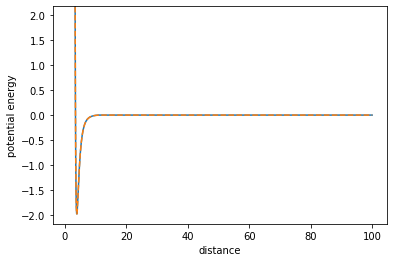

In [84]:
plt.plot(distances, pe)

plt.plot(distances, pe_theory, ls='--')
plt.ylim(pe.min()*1.1, -pe.min()*1.1)
plt.xlabel('distance')
plt.ylabel('potential energy')

## check image convertion

In [75]:
image = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [1, -1, -1],
    [0, 0, 1],
])

In [76]:
NeighborList.convert_ghostimage_to_3d(
 NeighborList.convert_ghostimage_to_1d(image)
)

array([[ 1,  0,  0],
       [ 1,  1,  0],
       [ 1, -1, -1],
       [ 0,  0,  1]], dtype=int8)

## check neighbor lists

In [498]:
position=np.array([[0,0,0],
                   [8,0,0]])
box = np.array([
    [10,0,0],
    [0,10,0],
    [0,0,10]
])
neigh = NeighborList(
    position, box, [2.0]
    )

neigh.build_neighborlist()

neigh.convert_ghostimage_to_3d(neigh.ghost_images[0,:1])

array([[-1,  0,  0]], dtype=int8)